# **FOUNDAMENTAL APPROACH - COCHRANE (1992) VAR MODEL EXTENSION**

### **1) REQUIREMENTS SETUP**

In [2]:
# !pip install -r requirements.txt

In [52]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

### **2) MONTHLY ANALYSIS**

##### **2.1) VARIABLES CONSTRUCTION**

In [4]:
# Log Risk Free Rate
rf_df = pd.read_csv("../data_extraction/raw_df/risk_free_monthly_df.csv")
rf_df = rf_df.rename(columns={"1-month Yield - US Treasury Securities":"Rf_t"})
rf_df["Date"] = pd.to_datetime(rf_df["Date"])

# Data Cleaning for NaN, -inf, 0.0 
rf_df["Rf_t"] = pd.to_numeric(rf_df["Rf_t"], errors="coerce") 
rf_df["Rf_t"] = rf_df["Rf_t"].replace([0, 0.0, -np.inf, np.inf], np.nan)

# (!!!) Either forward or backward filling
rf_df["Rf_t"] = rf_df["Rf_t"].ffill().bfill()

rf_df["rf_t"] = np.log(rf_df["Rf_t"])

rf_df.tail()

,Date,Rf_t,rf_t
282,2025-07-01,4.32,1.463255
283,2025-08-01,4.49,1.501853
284,2025-09-01,4.41,1.483875
285,2025-10-01,4.17,1.427916
286,2025-11-01,4.06,1.401183


In [5]:
# Log Synthetic Index Price
p_df = pd.read_csv("../data_extraction/raw_df/synthetic_price_monthly_df.csv")
p_df["p_t"] = np.log(p_df["Synthetic Index Close Price"])
p_df = p_df.rename(columns={"Synthetic Index Close Price":"P_t"})
p_df["Date"] = pd.to_datetime(p_df["Date"].astype(str).str[:10], format="%Y-%m-%d")
p_df.tail()

,Date,P_t,p_t
282,2025-07-01,333.452353,5.809500
283,2025-08-01,340.753141,5.831158
284,2025-09-01,348.811723,5.854532
285,2025-10-01,366.551887,5.904140
286,2025-11-01,375.118033,5.927241


In [6]:
# Log Synthetic Index Dividend - Seasonally Adjusted
d_df = pd.read_csv("../data_extraction/raw_df/synthetic_div_monthly_df.csv")

# Dividends payout with rolling window=12
d_df["D_t"] = d_df["Synthetic Index Dividend"].rolling(window=12, min_periods=12).sum()

# Log of D_t
d_df["d_t"] = np.log(d_df["D_t"])
d_df = d_df.drop(columns=["Synthetic Index Dividend"])

d_df["Date"] = pd.to_datetime(d_df["Date"].astype(str).str[:10], format="%Y-%m-%d")
d_df = d_df.dropna()
d_df

,Date,D_t,d_t
11,2002-12-01,0.033602,-3.393184
12,2003-01-01,0.033601,-3.393210
13,2003-02-01,0.046343,-3.071691
14,2003-03-01,0.046835,-3.061119
15,2003-04-01,0.046006,-3.078981
...,...,...,...
282,2025-07-01,2.022016,0.704095
283,2025-08-01,2.059450,0.722439
284,2025-09-01,2.074903,0.729915
285,2025-10-01,2.101338,0.742574


In [7]:
# Merged Variable Dataset
monthly_df = pd.merge(p_df, d_df, on="Date", how="outer")
monthly_df = pd.merge(monthly_df, rf_df, on="Date", how="outer")

monthly_df

,Date,P_t,p_t,D_t,d_t,Rf_t,rf_t
0,2002-01-01,6.741954,1.908350,NaN,NaN,1.69,0.524729
1,2002-02-01,6.708014,1.903303,NaN,NaN,1.69,0.524729
2,2002-03-01,6.614498,1.889264,NaN,NaN,1.78,0.576613
3,2002-04-01,6.714867,1.904324,NaN,NaN,1.79,0.582216
4,2002-05-01,6.022081,1.795433,NaN,NaN,1.76,0.565314
...,...,...,...,...,...,...,...
282,2025-07-01,333.452353,5.809500,2.022016,0.704095,4.32,1.463255
283,2025-08-01,340.753141,5.831158,2.059450,0.722439,4.49,1.501853
284,2025-09-01,348.811723,5.854532,2.074903,0.729915,4.41,1.483875
285,2025-10-01,366.551887,5.904140,2.101338,0.742574,4.17,1.427916


In [8]:
# Log Gross Return (Approximation)
monthly_df["r_t+1"] = monthly_df["p_t"].shift(-1) - monthly_df["p_t"] + np.log(1 + monthly_df["D_t"].shift(-1) / monthly_df["P_t"])
monthly_df

,Date,P_t,p_t,D_t,d_t,Rf_t,rf_t,r_t+1
0,2002-01-01,6.741954,1.908350,NaN,NaN,1.69,0.524729,NaN
1,2002-02-01,6.708014,1.903303,NaN,NaN,1.69,0.524729,NaN
2,2002-03-01,6.614498,1.889264,NaN,NaN,1.78,0.576613,NaN
3,2002-04-01,6.714867,1.904324,NaN,NaN,1.79,0.582216,NaN
4,2002-05-01,6.022081,1.795433,NaN,NaN,1.76,0.565314,NaN
...,...,...,...,...,...,...,...,...
282,2025-07-01,333.452353,5.809500,2.022016,0.704095,4.32,1.463255,0.027815
283,2025-08-01,340.753141,5.831158,2.059450,0.722439,4.49,1.501853,0.029445
284,2025-09-01,348.811723,5.854532,2.074903,0.729915,4.41,1.483875,0.055614
285,2025-10-01,366.551887,5.904140,2.101338,0.742574,4.17,1.427916,0.028322


In [9]:
# Log Excess Return 
monthly_df["rx_t+1"] = monthly_df["r_t+1"] - monthly_df["rf_t"].shift(-1)
monthly_df

,Date,P_t,p_t,D_t,d_t,Rf_t,rf_t,r_t+1,rx_t+1
0,2002-01-01,6.741954,1.908350,NaN,NaN,1.69,0.524729,NaN,NaN
1,2002-02-01,6.708014,1.903303,NaN,NaN,1.69,0.524729,NaN,NaN
2,2002-03-01,6.614498,1.889264,NaN,NaN,1.78,0.576613,NaN,NaN
3,2002-04-01,6.714867,1.904324,NaN,NaN,1.79,0.582216,NaN,NaN
4,2002-05-01,6.022081,1.795433,NaN,NaN,1.76,0.565314,NaN,NaN
...,...,...,...,...,...,...,...,...,...
282,2025-07-01,333.452353,5.809500,2.022016,0.704095,4.32,1.463255,0.027815,-1.474037
283,2025-08-01,340.753141,5.831158,2.059450,0.722439,4.49,1.501853,0.029445,-1.454430
284,2025-09-01,348.811723,5.854532,2.074903,0.729915,4.41,1.483875,0.055614,-1.372302
285,2025-10-01,366.551887,5.904140,2.101338,0.742574,4.17,1.427916,0.028322,-1.372861


In [10]:
# Log Excess Return 
monthly_df["Δd_t+1"] = monthly_df["d_t"].shift(-1) - monthly_df["d_t"]
monthly_df

,Date,P_t,p_t,D_t,d_t,Rf_t,rf_t,r_t+1,rx_t+1,Δd_t+1
0,2002-01-01,6.741954,1.908350,NaN,NaN,1.69,0.524729,NaN,NaN,NaN
1,2002-02-01,6.708014,1.903303,NaN,NaN,1.69,0.524729,NaN,NaN,NaN
2,2002-03-01,6.614498,1.889264,NaN,NaN,1.78,0.576613,NaN,NaN,NaN
3,2002-04-01,6.714867,1.904324,NaN,NaN,1.79,0.582216,NaN,NaN,NaN
4,2002-05-01,6.022081,1.795433,NaN,NaN,1.76,0.565314,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
282,2025-07-01,333.452353,5.809500,2.022016,0.704095,4.32,1.463255,0.027815,-1.474037,0.018344
283,2025-08-01,340.753141,5.831158,2.059450,0.722439,4.49,1.501853,0.029445,-1.454430,0.007475
284,2025-09-01,348.811723,5.854532,2.074903,0.729915,4.41,1.483875,0.055614,-1.372302,0.012660
285,2025-10-01,366.551887,5.904140,2.101338,0.742574,4.17,1.427916,0.028322,-1.372861,-0.090783


In [11]:
# Log Dividend-Price Ratio
monthly_df["dp_t"] = monthly_df["d_t"] - monthly_df["p_t"]

# Remove obs/date for the first lagged obs
monthly_df = monthly_df.dropna()
monthly_df

,Date,P_t,p_t,D_t,d_t,Rf_t,rf_t,r_t+1,rx_t+1,Δd_t+1,dp_t
11,2002-12-01,5.496798,1.704166,0.033602,-3.393184,1.25,0.223144,-0.117048,-0.299369,-0.000025,-5.097350
12,2003-01-01,4.859930,1.581024,0.033601,-3.393210,1.20,0.182322,-0.044532,-0.201536,0.321519,-4.974234
13,2003-02-01,4.604349,1.527001,0.046343,-3.071691,1.17,0.157004,0.020548,-0.170072,0.010572,-4.598692
14,2003-03-01,4.652612,1.537429,0.046835,-3.061119,1.21,0.190620,0.024635,-0.132368,-0.017862,-4.598548
15,2003-04-01,4.721963,1.552225,0.046006,-3.078981,1.17,0.157004,0.088306,0.002128,-0.000075,-4.631206
...,...,...,...,...,...,...,...,...,...,...,...
281,2025-06-01,314.297737,5.750341,2.034056,0.710032,4.33,1.465568,0.065572,-1.397683,-0.005937,-5.040309
282,2025-07-01,333.452353,5.809500,2.022016,0.704095,4.32,1.463255,0.027815,-1.474037,0.018344,-5.105405
283,2025-08-01,340.753141,5.831158,2.059450,0.722439,4.49,1.501853,0.029445,-1.454430,0.007475,-5.108719
284,2025-09-01,348.811723,5.854532,2.074903,0.729915,4.41,1.483875,0.055614,-1.372302,0.012660,-5.124618


##### **2.2) TRAIN/TEST SPLIT**

In [12]:
# Train & Test Split 
monthly_df.to_csv("FVM_data/raw_monthly_df.csv", index=False)

train_monthly_df = monthly_df[monthly_df["Date"] <= "2021-12-31"]
train_monthly_df.to_csv("FVM_data/train_monthly_df.csv", index=False)

test_monthly_df = monthly_df[monthly_df["Date"] >= "2021-12-31"]
test_monthly_df.to_csv("FVM_data/test_monthly_df.csv", index=False)

##### **2.3) VAR MODEL**

In [13]:
# Clean the df for state space vector 
# (!!!) Transfrom date in index and covert value columns to numeric
train_monthly_df = train_monthly_df[["Date", "rx_t+1", "Δd_t+1", "dp_t"]]
train_monthly_df = train_monthly_df.set_index("Date")
train_monthly_df = train_monthly_df.apply(pd.to_numeric, errors="coerce")

train_monthly_df.tail()

,rx_t+1,Δd_t+1,dp_t
Date,,,
2021-08-01,3.285507,0.004778,-4.967826
2021-09-01,2.478184,0.002502,-5.022711
2021-10-01,3.061767,0.019916,-4.966083
2021-11-01,2.411935,-0.131318,-5.005116
2021-12-01,2.872358,0.001693,-5.134562


In [14]:
# VAR model lag optimization
# (!!!) We prioritize AIC and FPE (lag=5) as we are interest in the best lag that maximize the reuslt in out-of-sample prediction
# (!!!) Parsimony-based index instead suggest a lag=2

m_model = VAR(train_monthly_df)
lag_selection = m_model.select_order(maxlags=10)
print(lag_selection.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -3.283      -3.236     0.03752      -3.264
1       -9.989     -9.804*   4.589e-05      -9.914
2      -10.09*      -9.761  4.166e-05*     -9.955*
3       -10.04      -9.571   4.383e-05      -9.848
4       -9.972      -9.368   4.672e-05      -9.728
5       -9.909      -9.166   4.978e-05      -9.609
6       -9.861      -8.979   5.225e-05      -9.504
7       -9.812      -8.791   5.488e-05      -9.400
8       -9.762      -8.601   5.779e-05      -9.293
9       -9.686      -8.386   6.241e-05      -9.161
10      -9.657      -8.218   6.436e-05      -9.076
--------------------------------------------------


d:\Conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
# VAR model (lag=2)
VAR_m_model = m_model.fit(2)
print(VAR_m_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Nov, 2025
Time:                     06:02:34
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -9.84648
Nobs:                     227.000    HQIC:                  -10.0355
Log likelihood:           208.240    FPE:                3.85612e-05
AIC:                     -10.1633    Det(Omega_mle):     3.52030e-05
--------------------------------------------------------------------
Results for equation rx_t+1
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.131247         0.368794           -0.356           0.722
L1.rx_t+1         0.648430         0.064504           10.053           0.000
L1.Δd_t+1        -0.117623         0.208780           -0.563           0.57

##### **2.4) MODEL TRAINING**

In [16]:
# Data Training Function
# (!!!) Change model specification
def data_training(model, original_df):
    train_fitted = model.fittedvalues.copy()

# Rename columns for fitted data and create a new df 
# (!!!) The time filtering is already performed by "inner"
    train_fitted.columns = [c + "_fitted" for c in train_fitted.columns]
    train_and_fit = pd.merge(original_df, train_fitted, on="Date", how="inner")

# Train Results Dataset
    train_results = train_and_fit.copy()

#////////////////////////////////////////////////////////////////
# Dividend Extraction
# Train D_t=0: 0.03360150420168
# Test D_t=0: 1.0887532677258398
    growth = np.exp(train_results["Δd_t+1_fitted"])
    D = np.empty(len(train_results))
    D0_train = 0.03360150420168
    for t in range(len(train_results)):
        if t == 0:
            D[t] = D0_train * growth.iloc[t]
        else:
            D[t] = D[t-1] * growth.iloc[t]
    train_results["D_t_PVM"] = D
# Price Extraction: pt=Dt/e^dpt
    train_results["P_t_PVM"] = train_results["D_t_PVM"] / np.exp(train_results["dp_t_fitted"])
#////////////////////////////////////////////////////////////////

# Mismatch Measures 
    train_results["Mispricing Actual-PVM"] = train_results["P_t"] - train_results["P_t_PVM"]
    train_results["Mispricing Ratio PVM"] = train_results["P_t"] / train_results["P_t_PVM"] - 1
    train_results["Nature"] = "In-Sample Training"

    return train_results

In [17]:
# In-Sample Data Training Monthly (until 2021/12/01)

monthly_train_results = data_training(VAR_m_model, monthly_df)
monthly_train_results

,Date,P_t,p_t,D_t,d_t,Rf_t,rf_t,r_t+1,rx_t+1,Δd_t+1,dp_t,rx_t+1_fitted,Δd_t+1_fitted,dp_t_fitted,D_t_PVM,P_t_PVM,Mispricing Actual-PVM,Mispricing Ratio PVM,Nature
0,2003-02-01,4.604349,1.527001,0.046343,-3.071691,1.17,0.157004,0.020548,-0.170072,0.010572,-4.598692,-0.116158,0.019151,-4.658490,0.034251,3.612704,0.991645,0.274488,In-Sample Training
1,2003-03-01,4.652612,1.537429,0.046835,-3.061119,1.21,0.190620,0.024635,-0.132368,-0.017862,-4.598548,-0.048759,0.041860,-4.596284,0.035715,3.539945,1.112667,0.314318,In-Sample Training
2,2003-04-01,4.721963,1.552225,0.046006,-3.078981,1.17,0.157004,0.088306,0.002128,-0.000075,-4.631206,-0.053532,0.046552,-4.627612,0.037417,3.826656,0.895307,0.233966,In-Sample Training
3,2003-05-01,5.108140,1.630835,0.046003,-3.079057,1.09,0.086178,0.052223,-0.096197,0.013660,-4.709892,0.041689,0.047341,-4.641499,0.039231,4.068275,1.039865,0.255604,In-Sample Training
4,2003-06-01,5.333300,1.673970,0.046635,-3.065396,1.16,0.148420,0.033527,0.150060,-0.002939,-4.739366,0.001797,0.061555,-4.712417,0.041722,4.644543,0.688756,0.148294,In-Sample Training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,2021-08-01,173.639478,5.156981,1.208228,0.189155,0.05,-2.995732,0.066631,3.285507,0.004778,-4.967826,3.025003,0.076095,-4.945513,0.574523,80.745131,92.894346,1.150464,In-Sample Training
223,2021-09-01,184.314724,5.216645,1.214015,0.193933,0.04,-3.218876,-0.047545,2.478184,0.002502,-5.022711,3.182843,0.078343,-4.980794,0.621343,90.461334,93.853390,1.037497,In-Sample Training
224,2021-10-01,174.603609,5.162518,1.217056,0.196435,0.08,-2.525729,0.066035,3.061767,0.019916,-4.966083,2.731721,0.082512,-5.053631,0.674786,105.664796,68.938814,0.652429,In-Sample Training
225,2021-11-01,185.205830,5.221468,1.241539,0.216352,0.05,-2.995732,0.003989,2.411935,-0.131318,-5.005116,2.889201,0.062360,-4.953934,0.718205,101.792270,83.413560,0.819449,In-Sample Training


##### **2.4) MODEL FORECAST**

In [18]:
# Out-Sample Data Training (2022/12/01 - 2025/11/01)
# (!!!) Change model specification
def data_testing(model, original_df, test_df):

# General set up of the VAR specification
# Get variables' names
    df = test_df.copy().reset_index(drop=True)
    var_cols = model.names 
# VAR lag order 
    p = model.k_ar
# (!!!) Initial history comes from the training sample inside the VAR model
    history = model.model.endog[-p:].copy()
    predictions = []

# Actual Forecast
# Forecast for each period t
    for t in range(len(df)):
        forecast = model.forecast(history[-p:], steps=1)[0]
        predictions.append(forecast)
# (!!!) We append this prediction to history (recursive forecasting)
        history = np.vstack([history, forecast])

# Predictions df
    pred_results = pd.DataFrame(predictions,
                           columns=[c + "_fitted" for c in var_cols])
    pred_results["Date"] = df["Date"].values

    
# Rename columns for fitted data and create a new df 
# (!!!) The time filtering is already performed by "inner"
    test_and_fit = pd.merge(original_df, pred_results, on="Date", how="inner")

# Test results dataset
    test_results = test_and_fit.copy()

#/////////////////////////////////////////////////
# Dividend Extraction
# Train D_t=0: 0.03360150420168
# Test D_t=0: 0.7907552641165884
    growth = np.exp(test_results["Δd_t+1_fitted"])
    D = np.empty(len(test_results))
    D0_test = 0.7907552641165884
    for t in range(len(test_results)):
        if t == 0:
            D[t] = D0_test * growth.iloc[t]
        else:
            D[t] = D[t-1] * growth.iloc[t]
    test_results["D_t_PVM"] = D
# Price Extraction: pt=Dt/e^dpt
    test_results["P_t_PVM"] = test_results["D_t_PVM"] / np.exp(test_results["dp_t_fitted"])
#/////////////////////////////////////////////////

# Mismatch Measures 
    test_results["Mispricing Actual-PVM"] = test_results["P_t"] - test_results["P_t_PVM"]
    test_results["Mispricing Ratio PVM"] = test_results["P_t"] / test_results["P_t_PVM"] - 1
    test_results["Nature"] = "Out-Sample Testing"

    return test_results

In [19]:
# Out-Sample Data Testing Monthly (2022/12/01 - 2025/11/01)

monthly_test_results = data_testing(VAR_m_model, monthly_df, test_monthly_df)
monthly_test_results

,Date,P_t,p_t,D_t,d_t,Rf_t,rf_t,r_t+1,rx_t+1,Δd_t+1,dp_t,rx_t+1_fitted,Δd_t+1_fitted,dp_t_fitted,D_t_PVM,P_t_PVM,Mispricing Actual-PVM,Mispricing Ratio PVM,Nature
0,2022-01-01,194.933937,5.272661,1.090598,0.086727,0.06,-2.813411,-0.062171,3.156705,0.017353,-5.185934,2.728866,0.081640,-5.144216,0.858021,147.096670,47.837267,0.325210,Out-Sample Testing
1,2022-02-01,182.146812,5.204813,1.109689,0.104080,0.04,-3.218876,-0.086294,2.120981,0.004852,-5.100733,2.776552,0.077759,-5.084020,0.927403,149.702956,32.443855,0.216722,Out-Sample Testing
2,2022-03-01,166.071109,5.112416,1.115086,0.108932,0.11,-2.207275,0.074951,1.972071,-0.001934,-5.003484,2.761494,0.077537,-5.024951,1.002173,152.493332,13.577777,0.089038,Out-Sample Testing
3,2022-04-01,177.805083,5.180688,1.112932,0.106998,0.15,-1.897120,-0.113726,0.880526,0.052729,-5.073690,2.764717,0.072261,-4.967065,1.077271,154.701325,23.103759,0.149344,Out-Sample Testing
4,2022-05-01,157.651267,5.060385,1.173191,0.159728,0.37,-0.994252,-0.017423,0.243941,0.005821,-4.900658,2.759579,0.068478,-4.914245,1.153625,157.142747,0.508520,0.003236,Out-Sample Testing
5,2022-06-01,153.777213,5.035505,1.180041,0.165549,0.77,-0.261365,-0.086108,-0.325125,0.003041,-4.869956,2.754933,0.064557,-4.865381,1.230557,159.628209,-5.850996,-0.036654,Out-Sample Testing
6,2022-07-01,140.012177,4.941729,1.183635,0.168590,1.27,0.239017,0.111256,-0.686251,0.040441,-4.773140,2.748133,0.061080,-4.820472,1.308062,162.230499,-22.218322,-0.136955,Out-Sample Testing
7,2022-08-01,155.123465,5.044221,1.232483,0.209031,2.22,0.797507,-0.042683,-0.970902,0.001265,-4.835191,2.740266,0.057834,-4.779105,1.385942,164.924036,-9.800571,-0.059425,Out-Sample Testing
8,2022-09-01,147.468548,4.993615,1.234042,0.210295,2.53,0.928219,-0.111398,-1.137440,0.002781,-4.783320,2.731186,0.054859,-4.741026,1.464097,167.714730,-20.246182,-0.120718,Out-Sample Testing
9,2022-10-01,130.824974,4.873860,1.237479,0.213076,2.79,1.026042,0.038879,-1.274844,0.011753,-4.660784,2.721129,0.052115,-4.705957,1.542422,170.598172,-39.773197,-0.233140,Out-Sample Testing


In [41]:
# Concat results dfs
monthly_fitted_df = pd.concat([monthly_train_results, monthly_test_results], 
                              axis=0, 
                              ignore_index=True)
monthly_fitted_df.to_csv("FVM_data/monthly_fitted_df.csv")
monthly_fitted_df

,Date,P_t,p_t,D_t,d_t,Rf_t,rf_t,r_t+1,rx_t+1,Δd_t+1,dp_t,rx_t+1_fitted,Δd_t+1_fitted,dp_t_fitted,D_t_PVM,P_t_PVM,Mispricing Actual-PVM,Mispricing Ratio PVM,Nature
0,2003-02-01,4.604349,1.527001,0.046343,-3.071691,1.17,0.157004,0.020548,-0.170072,0.010572,-4.598692,-0.116158,0.019151,-4.658490,0.034251,3.612704,0.991645,0.274488,In-Sample Training
1,2003-03-01,4.652612,1.537429,0.046835,-3.061119,1.21,0.190620,0.024635,-0.132368,-0.017862,-4.598548,-0.048759,0.041860,-4.596284,0.035715,3.539945,1.112667,0.314318,In-Sample Training
2,2003-04-01,4.721963,1.552225,0.046006,-3.078981,1.17,0.157004,0.088306,0.002128,-0.000075,-4.631206,-0.053532,0.046552,-4.627612,0.037417,3.826656,0.895307,0.233966,In-Sample Training
3,2003-05-01,5.108140,1.630835,0.046003,-3.079057,1.09,0.086178,0.052223,-0.096197,0.013660,-4.709892,0.041689,0.047341,-4.641499,0.039231,4.068275,1.039865,0.255604,In-Sample Training
4,2003-06-01,5.333300,1.673970,0.046635,-3.065396,1.16,0.148420,0.033527,0.150060,-0.002939,-4.739366,0.001797,0.061555,-4.712417,0.041722,4.644543,0.688756,0.148294,In-Sample Training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2025-06-01,314.297737,5.750341,2.034056,0.710032,4.33,1.465568,0.065572,-1.397683,-0.005937,-5.040309,2.284879,0.021810,-4.318773,4.123544,309.663260,4.634477,0.014966,Out-Sample Testing
269,2025-07-01,333.452353,5.809500,2.022016,0.704095,4.32,1.463255,0.027815,-1.474037,0.018344,-5.105405,2.273291,0.021596,-4.316038,4.213563,315.559162,17.893191,0.056703,Out-Sample Testing
270,2025-08-01,340.753141,5.831158,2.059450,0.722439,4.49,1.501853,0.029445,-1.454430,0.007475,-5.108719,2.261933,0.021395,-4.313485,4.304684,321.561477,19.191665,0.059683,Out-Sample Testing
271,2025-09-01,348.811723,5.854532,2.074903,0.729915,4.41,1.483875,0.055614,-1.372302,0.012660,-5.124618,2.250805,0.021208,-4.311101,4.396953,327.671793,21.139930,0.064516,Out-Sample Testing


##### **2.5) METRICS**

In [ ]:
# Performance Metrics
# (!!!) ngl, impressive metrics, especially for out-sample testing
# (!!!) Previous alternative models had abnormal results (check lit)

def compute_metrics(df, label):
    df = df.dropna(subset=["P_t", "P_t_PVM"])
# RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean((df["P_t_PVM"] - df["P_t"])**2))
# MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((df["P_t_PVM"] - df["P_t"]) / df["P_t"])) * 100
# CORR (Correlation (Actual vs PVM Price))
    corr = df["P_t"].corr(df["P_t_PVM"])
# SS_RES
    ss_res = np.sum((df["P_t"] - df["P_t_PVM"])**2)
# SS_TOT
    ss_tot = np.sum((df["P_t"] - df["P_t"].mean())**2)
# R2 (Pseudo R²)
    r2 = 1 - ss_res / ss_tot
    print(f"\n=== {label} PVM Performance ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Correlation (P_t vs P_t_PVM): {corr:.4f}")
    print(f"Pseudo R²: {r2:.4f}")

compute_metrics(monthly_train_results, "In-Sample (train)")
compute_metrics(monthly_test_results, "Out-Sample (test)")


=== In-Sample (train) PVM Performance ===
RMSE: 41.4856
MAPE: 76.72%
Correlation (P_t vs P_t_PVM): 0.8398
Pseudo R²: 0.0146

=== Out-Sample (test) PVM Performance ===
RMSE: 21.9991
MAPE: 9.46%
Correlation (P_t vs P_t_PVM): 0.9540
Pseudo R²: 0.8926


##### **2.6) PLOTTING**

<Figure size 1000x500 with 0 Axes>

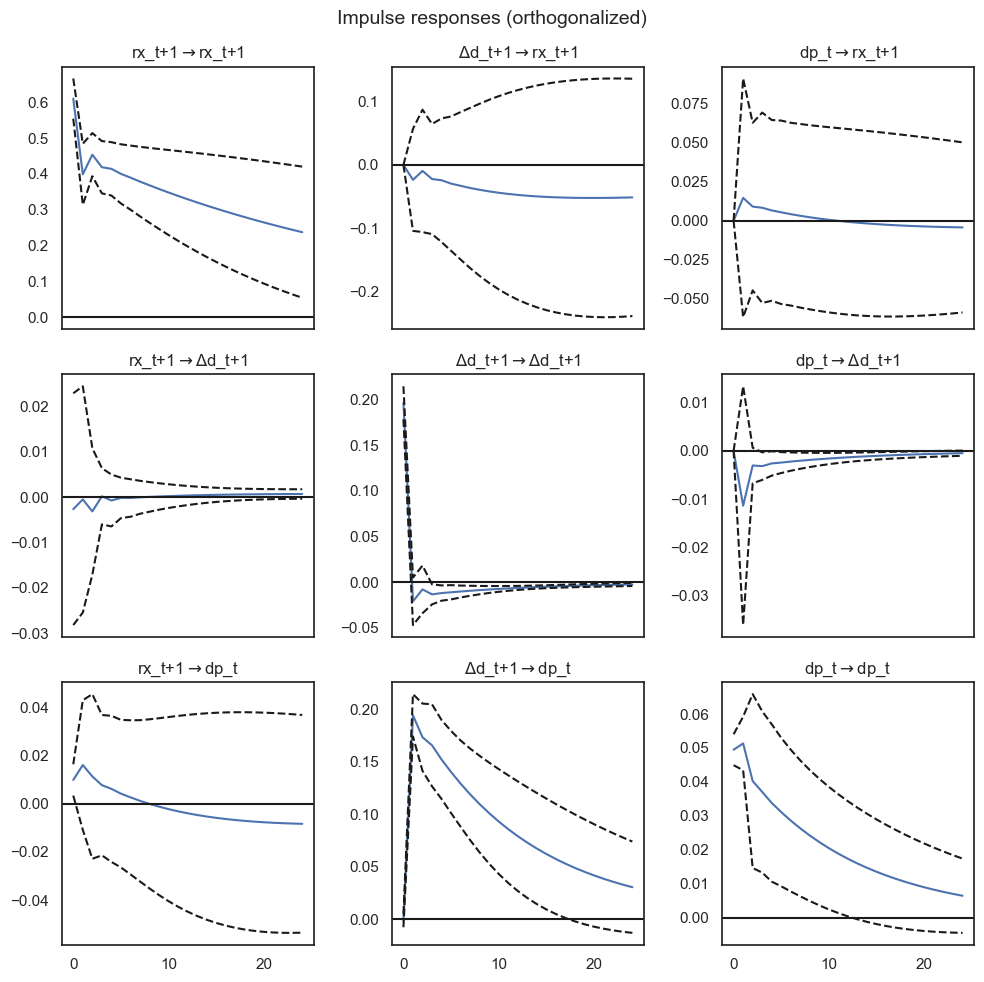

In [51]:
# VAR impulse response function plotting
# (!!!) Responses die after 15 month on average: stable VAR
# (!!!) Smooth and monotonic reactions (no explosivity)
# (!!!)

# Horizon for IRFs
# (!!!) Reaction over the next 24 months
irf_horizon = 24 
# IRFs computation per each variable
irf = VAR_m_model.irf(irf_horizon)


plt.figure(figsize=(10, 5))
irf.plot(orth=True)
plt.tight_layout()
plt.show()

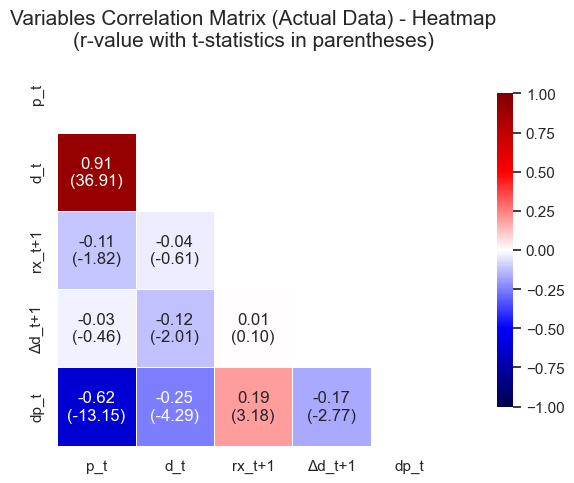

In [43]:
# Actual Data Plotting (Correlation Heatmap)
filtered_fitted_monthly_df = monthly_fitted_df[["p_t", "d_t", "rx_t+1", "Δd_t+1", "dp_t"]]

# Correlation matrix
corr_matrix = filtered_fitted_monthly_df.corr()
# Sample size
n = filtered_fitted_monthly_df.shape[0]

# t-statistics derived from correlation values
with np.errstate(divide="ignore", invalid="ignore"):
    t_stat_matrix = corr_matrix * np.sqrt((n - 2) / (1 - corr_matrix**2))
    t_stat_matrix = t_stat_matrix.round(2)

# For each cell, we want to have both the correlation index, as well as the just computed t-statistics
annot_matrix = corr_matrix.copy().astype(str)

for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
# We only want to keep the lower triangle and diagonal of the full correlation matrix
        if i >= j: 
            r = corr_matrix.iloc[i, j]
            t = t_stat_matrix.iloc[i, j]
            annot_matrix.iloc[i, j] = f"{r:.2f}\n({t:.2f})"
        else:
            annot_matrix.iloc[i, j] = ""

# We manually hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heat-map plot
# General Layout (figure's size and style)
plt.figure(figsize=(10, 5))
sns.set(style="white")

sns.heatmap(corr_matrix,
            mask=mask,
            annot=annot_matrix,
            fmt="",               
            cmap="seismic",          
            vmin=-1, vmax=1,       
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8})


plt.title("Variables Correlation Matrix (Actual Data) - Heatmap\n(r-value with t-statistics in parentheses)", 
          fontsize=15)
plt.tight_layout()
plt.show()

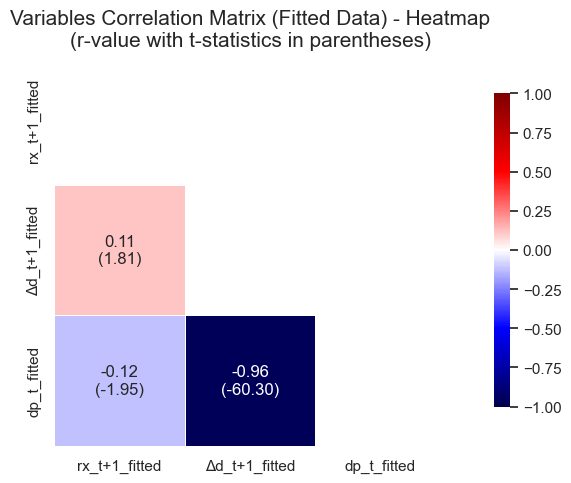

In [45]:
# Forecasted Data Plotting (Correlation Heatmap)
filtered_fitted_monthly_df = monthly_fitted_df[["rx_t+1_fitted", "Δd_t+1_fitted", "dp_t_fitted"]]

# Correlation matrix
corr_matrix = filtered_fitted_monthly_df.corr()
# Sample size
n = filtered_fitted_monthly_df.shape[0]

# t-statistics derived from correlation values
with np.errstate(divide="ignore", invalid="ignore"):
    t_stat_matrix = corr_matrix * np.sqrt((n - 2) / (1 - corr_matrix**2))
    t_stat_matrix = t_stat_matrix.round(2)

# For each cell, we want to have both the correlation index, as well as the just computed t-statistics
annot_matrix = corr_matrix.copy().astype(str)

for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
# We only want to keep the lower triangle and diagonal of the full correlation matrix
        if i >= j: 
            r = corr_matrix.iloc[i, j]
            t = t_stat_matrix.iloc[i, j]
            annot_matrix.iloc[i, j] = f"{r:.2f}\n({t:.2f})"
        else:
            annot_matrix.iloc[i, j] = ""

# We manually hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heat-map plot
# General Layout (figure's size and style)
plt.figure(figsize=(10, 5))
sns.set(style="white")

sns.heatmap(corr_matrix,
            mask=mask,
            annot=annot_matrix,
            fmt="",               
            cmap="seismic",          
            vmin=-1, vmax=1,       
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8})

plt.title("Variables Correlation Matrix (Fitted Data) - Heatmap\n(r-value with t-statistics in parentheses)", 
          fontsize=15)
plt.tight_layout()
plt.show()

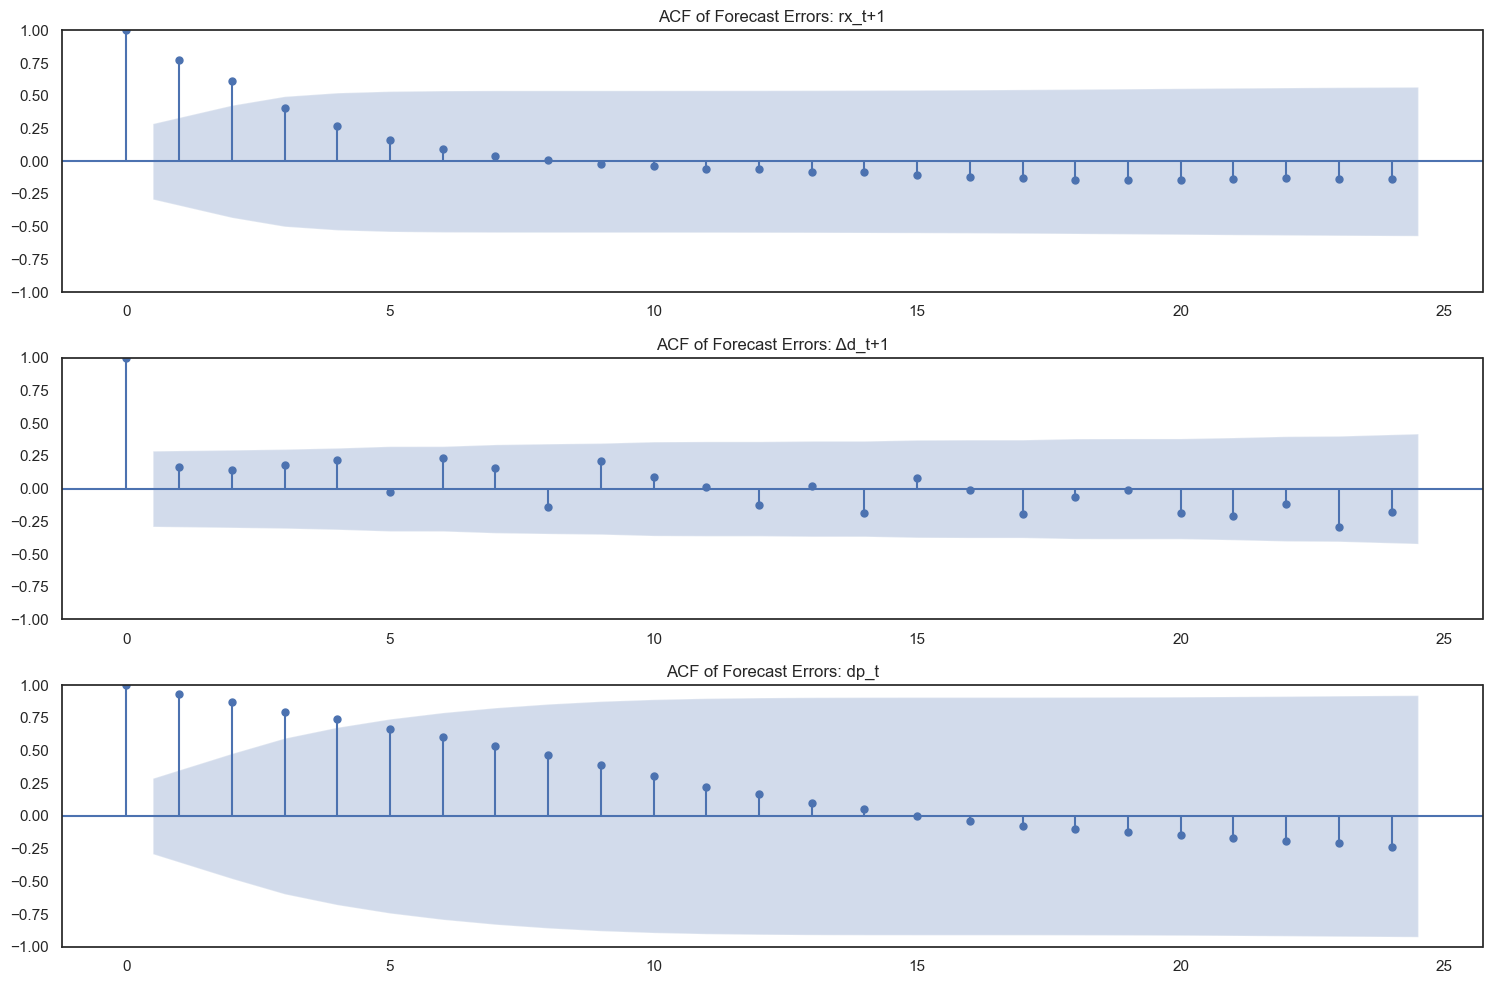

In [ ]:
# Autocorrelation of Forecast Errors (ACF) plotting (out-sample testing)
# (!!!) We verify if the model leaves serial correlation in errors (autocorrelation test)
# (!!!) Weakly autocorrelated white-noise process beyond lag 5
# (!!!) Higher and more persistent autocorrelation until lag 10-12 of dpt given the 12-month window on which it is computed

# ACF Computation
plot_df = monthly_test_results

actual_vars = ["rx_t+1", "Δd_t+1", "dp_t"]
forecast_vars = ["rx_t+1_fitted", "Δd_t+1_fitted", "dp_t_fitted"]

errors = {}
for a, f in zip(actual_vars, forecast_vars):
    errors[a] = plot_df[a] - plot_df[f]

# ACF Plotting
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i, var in enumerate(actual_vars):
    plot_acf(errors[var].dropna(), lags=24, ax=axes[i])
    axes[i].set_title(f"ACF of Forecast Errors: {var}")

plt.tight_layout()
plt.show()

In [64]:
# plot dt and rt and dpt 

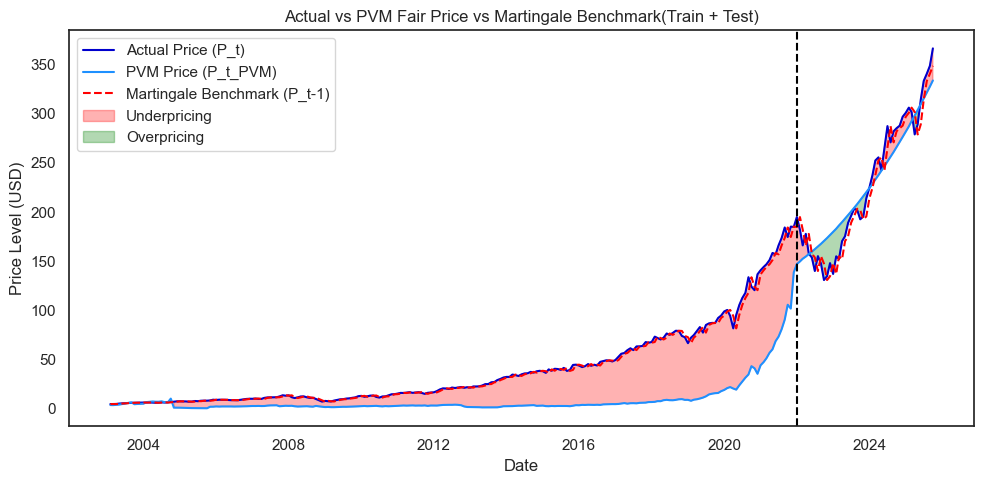

In [66]:
# Plotting Forecasted Price against Actual Price Over Time
plot_df = monthly_fitted_df

# Martingale benchmark - P_t^M = P_{t-1}
plot_df["P_t_martingale"] = plot_df["P_t"].shift(1)
plot_df.loc[plot_df.index[0], "P_t_martingale"] = plot_df["P_t"].iloc[0]

plt.figure(figsize=(10, 5))
plt.plot(plot_df["Date"], plot_df["P_t"], color = "mediumblue", label="Actual Price (P_t)")
plt.plot(plot_df["Date"], plot_df["P_t_PVM"], color = "dodgerblue", label="PVM Price (P_t_PVM)")
plt.plot(plot_df["Date"], plot_df["P_t_martingale"], linestyle="--", color="red", label="Martingale Benchmark (P_t-1)")

plt.fill_between(
    plot_df["Date"],
    plot_df["P_t"],
    plot_df["P_t_PVM"],
    where=(plot_df["P_t"] >= plot_df["P_t_PVM"]),
    alpha=0.3,
    color="red",
    label="Underpricing"
)

plt.fill_between(
    plot_df["Date"],
    plot_df["P_t"],
    plot_df["P_t_PVM"],
    where=(plot_df["P_t"] < plot_df["P_t_PVM"]),
    alpha=0.3,
    color="green",
    label="Overpricing"
)

split_date = pd.to_datetime("2022-01-01")
plt.axvline(split_date, linestyle="--", color="black")

plt.title("Actual vs PVM Fair Price vs Martingale Benchmark(Train + Test)")
plt.xlabel("Date")
plt.ylabel("Price Level (USD)")
plt.legend()
plt.tight_layout()
plt.show()

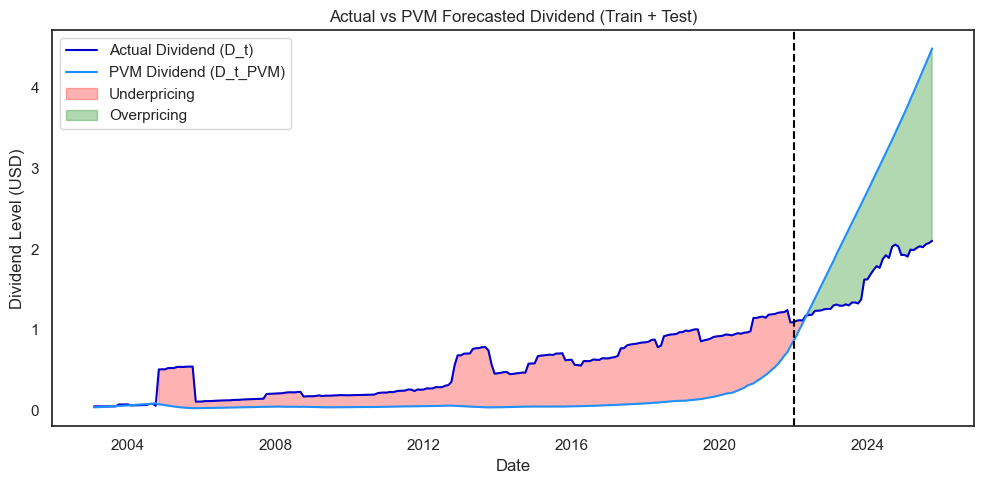

In [57]:
# Plotting Forecasted Dividend Payout against Actual Dividend Payout Over Time
plot_df = monthly_fitted_df

plt.figure(figsize=(10, 5))
plt.plot(plot_df["Date"], plot_df["D_t"], color = "mediumblue", label="Actual Dividend (D_t)")
plt.plot(plot_df["Date"], plot_df["D_t_PVM"], color = "dodgerblue", label="PVM Dividend (D_t_PVM)")

plt.fill_between(
    plot_df["Date"],
    plot_df["D_t"],
    plot_df["D_t_PVM"],
    where=(plot_df["D_t"] >= plot_df["D_t_PVM"]),
    alpha=0.3,
    color="red",
    label="Underpricing"
)

plt.fill_between(
    plot_df["Date"],
    plot_df["D_t"],
    plot_df["D_t_PVM"],
    where=(plot_df["D_t"] < plot_df["D_t_PVM"]),
    alpha=0.3,
    color="green",
    label="Overpricing"
)

split_date = pd.to_datetime("2022-01-01")
plt.axvline(split_date, linestyle="--", color="black")

plt.title("Actual vs PVM Forecasted Dividend (Train + Test)")
plt.xlabel("Date")
plt.ylabel("Dividend Level (USD)")
plt.legend()
plt.tight_layout()
plt.show()

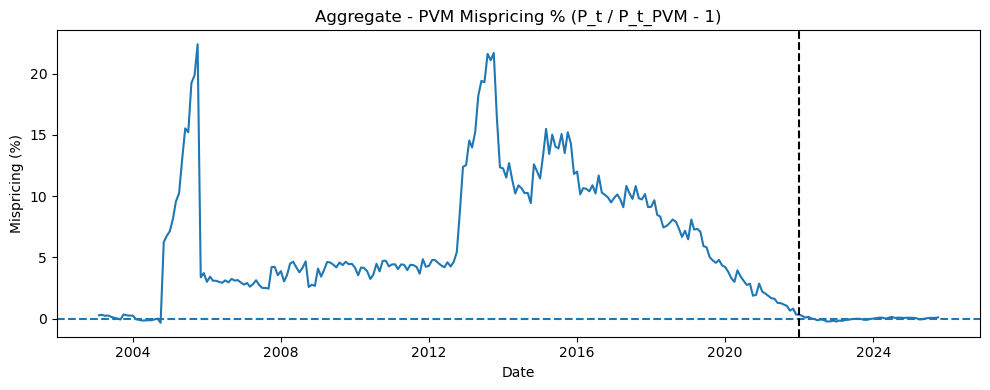

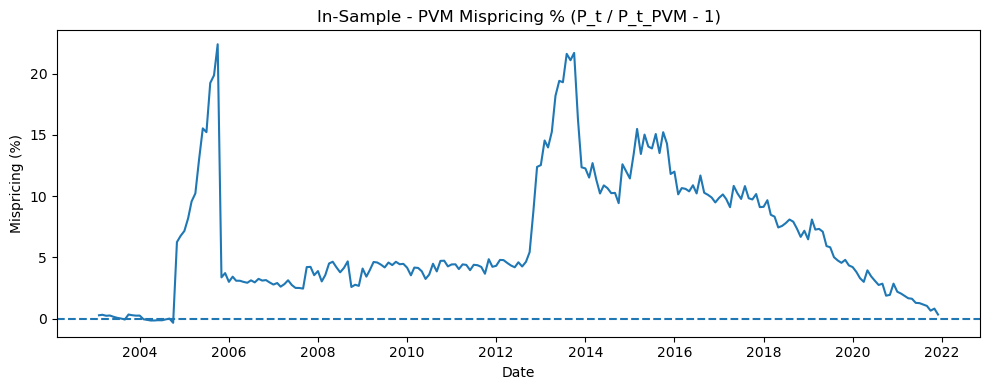

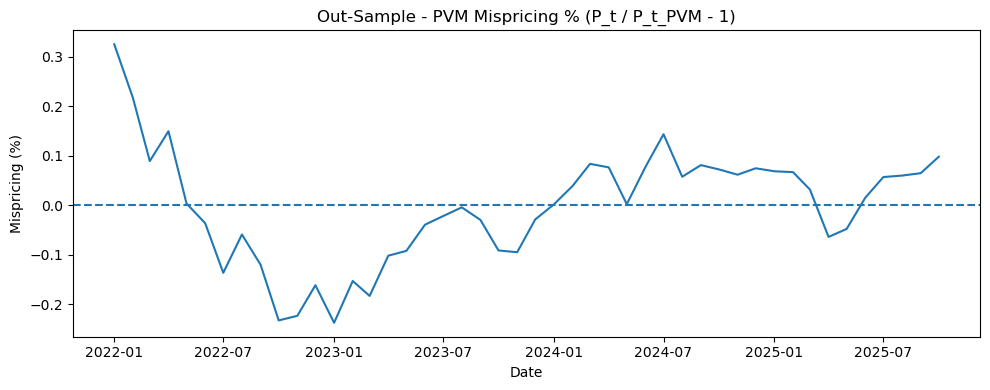

In [34]:
# Plotting Aggregate - PVM Mispricing % (P_t / P_t_PVM - 1)
plot_df = monthly_fitted_df
plt.figure(figsize=(10, 4))
plt.plot(plot_df["Date"], plot_df["Mispricing Ratio PVM"])
plt.axhline(0, linestyle="--")
plt.axvline(split_date, linestyle="--", color="black")
plt.title("Aggregate - PVM Mispricing % (P_t / P_t_PVM - 1)")
plt.xlabel("Date")
plt.ylabel("Mispricing (%)")
plt.tight_layout()
plt.show()

# Plotting In-Sample - PVM Mispricing % (P_t / P_t_PVM - 1)
plot_df = monthly_train_results
plt.figure(figsize=(10, 4))
plt.plot(plot_df["Date"], plot_df["Mispricing Ratio PVM"])
plt.axhline(0, linestyle="--")
plt.title("In-Sample - PVM Mispricing % (P_t / P_t_PVM - 1)")
plt.xlabel("Date")
plt.ylabel("Mispricing (%)")
plt.tight_layout()
plt.show()

# Plotting Out-Sample - PVM Mispricing % (P_t / P_t_PVM - 1)
plot_df = monthly_test_results
plt.figure(figsize=(10, 4))
plt.plot(plot_df["Date"], plot_df["Mispricing Ratio PVM"])
plt.axhline(0, linestyle="--")
plt.title("Out-Sample - PVM Mispricing % (P_t / P_t_PVM - 1)")
plt.xlabel("Date")
plt.ylabel("Mispricing (%)")
plt.tight_layout()
plt.show()